# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
import random

import numpy as np
import torch
from unityagents import UnityEnvironment

from parameters import *

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

env = UnityEnvironment(seed=RANDOM_SEED, file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Train the Agent

In [7]:
from collections import deque


def train(ddpg, env, n_episodes=1000, max_t=1000, save_every=50):

    solved = False
    scores_total = []
    scores_deque = deque(maxlen=100)
    rolling_score_averages = []
    best_score = 0.0
    
    for i_episode in range(1, n_episodes+1):
        current_average = 0.0 if i_episode == 1 else rolling_score_averages[-1]
            
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations[:, -STATE_SIZE:]
        scores = np.zeros(num_agents)
        ddpg.reset()
        
        while True:
            actions = ddpg.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations[:, -STATE_SIZE:]
            rewards = env_info.rewards
            dones = env_info.local_done
            
            ddpg.step(states, actions, rewards, next_states, dones)
            
            scores += rewards
            states = next_states
            
            if np.any(dones):
                break
        
        max_episode_score = np.max(scores)
        
        scores_deque.append(max_episode_score)
        scores_total.append(max_episode_score)

        average_score = np.mean(scores_deque)
        rolling_score_averages.append(average_score)
        
        if average_score > best_score:
            best_score = average_score
            if solved:
                ddpg.save_model()
        
        if average_score >= 0.5 and not solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode, average_score
            ))
            solved = True
            ddpg.save_model()
        
        if i_episode % save_every == 0 and not solved:
            ddpg.save_model()
            print('\rEpisode {}\t\nScore: {:.2f}\t'.format(i_episode, average_score, end="")

    ddpg.save_model()

    return scores_total, rolling_score_averages

In [8]:
from ddpg_agent import DDPGAgent

ddpg = DDPGAgent(STATE_SIZE, ACTION_SIZE, NUM_AGENTS)

In [9]:
scores_total, rolling_score_averages = train(ddpg, env, n_episodes=1000)

Episode 50	
Episode 100	Last Score: -0.00
Episode 150	Last Score: -0.00
Episode 200	Last Score: -0.00
Episode 250	Last Score: -0.00
Episode 300	Last Score: -0.00
Episode 350	Last Score: -0.00
Episode 400	Last Score: 0.10
Episode 450	Last Score: 0.10
Episode 500	Last Score: 0.10
Episode 550	Last Score: 0.15
Episode 600	Last Score: 0.30
Episode 650	Last Score: 0.10
Episode 700	Last Score: -0.00
Episode 750	Last Score: 0.05
Episode 800	Last Score: 0.85
Episode 850	Last Score: 0.40
Episode 900	Last Score: 0.65
Episode 950	Last Score: 0.35
Episode 1000	ast Score: 0.20
Score: 0.41	Last Score: 0.15

In [10]:
import matplotlib.pyplot as plt

def plot_results(scores, rolling_score_averages):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(1, len(scores) + 1), scores, label="Max Score")
    plt.plot(np.arange(1, len(rolling_score_averages) + 1), rolling_score_averages, label="Rolling Average")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()

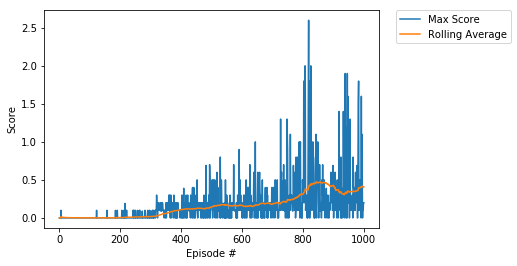

In [11]:
plot_results(scores_total, rolling_score_averages)